In [64]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve, precision_recall_curve
import pickle
sns.set()

In [65]:
# Load the dataset
file_path = 'C:/Users/yaici/OneDrive/Bureau/projet pfe/predictive_maintenance.csv'
data = pd.read_csv(file_path)
n = data.shape[0]
# First checks
print('Features non-null values and data type:')
data.info()
print('Check for duplicate values:',
      data['Product ID'].unique().shape[0]!=n)

Features non-null values and data type:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
Check for duplicate values: False


In [66]:
# Set numeric columns dtype to float
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')
# Rename features
data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

In [67]:
# Drop ID columns
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)

In [68]:
# Create lists of features and target names
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Portion of data where RNF=1
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


la panne "Random Failures"ne se produit que dans 18 observations et elle a une nature aléatoire donc non prévisible,
nous décidons donc de supprimer ces lignes.

In [69]:
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
# Drop corresponding observations and RNF column
df.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


In [70]:
df.shape

(9982, 8)

 nous découvrons que dans 9 observations, la défaillance de la machine est définie sur 1 lorsque tous les types de défaillances sont définis sur 0. Nous ne pouvons pas comprendre s'il y a vraiment eu une défaillance ou non, supprimons donc également ces observations.

In [71]:
# Portion of data where Machine failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [72]:
df.shape

(9973, 8)

In [73]:
# Global percentage of removed observations
print('Global percentage of removed observations:',
     (100*(first_drop+second_drop)/n))
df.reset_index(drop=True, inplace=True)   
n = df.shape[0]

Global percentage of removed observations: 0.27


Outliers inspection
L'objectif de cette section est de vérifier si l'ensemble de données contient des valeurs aberrantes, généralement trompeuses pour les algorithmes d'apprentissage automatique. Nous commençons par examiner un rapport statistique des caractéristiques numériques.

In [74]:
df.describe()


,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,300.003259,310.004031,1538.893212,39.978993,107.921087,0.033089
std,2.000548,1.483692,179.412171,9.966805,63.649152,0.178879
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


Nous pouvons deviner la présence de valeurs aberrantes pour Rotational Speed et Torque, car le maximum est très différent du troisième quartile. Pour concrétiser cette observation, examinons la situation de plus près à l'aide de boîtes à moustaches et d'histogrammes pour comprendre la distribution.

In [75]:
features

['Type',
 'Air temperature',
 'Process temperature',
 'Rotational speed',
 'Torque',
 'Tool wear']

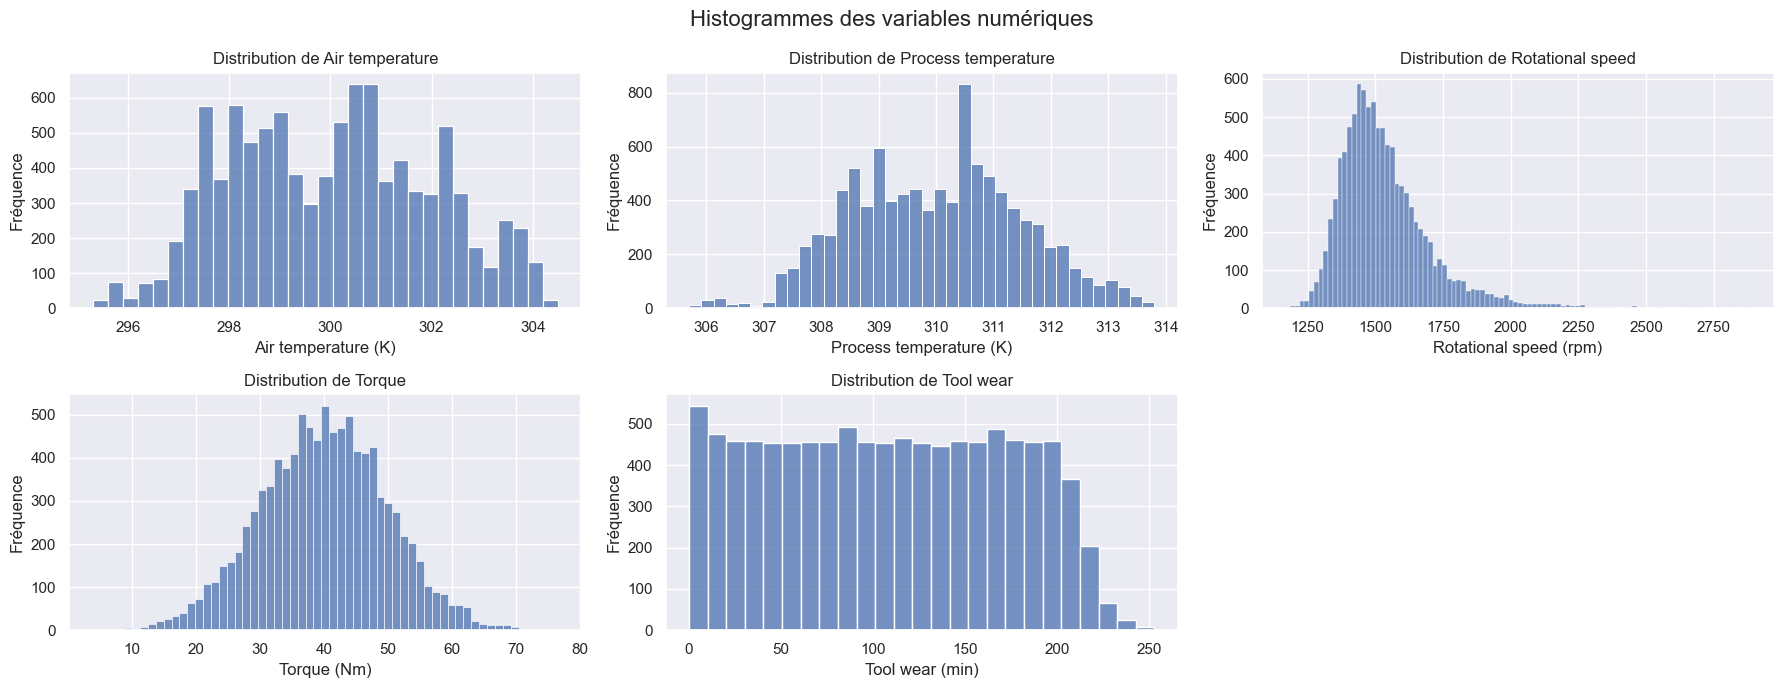

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionnaire des unités
units = {
    'Air temperature': 'K',
    'Process temperature': 'K',
    'Rotational speed': 'rpm',
    'Torque': 'Nm',
    'Tool wear': 'min'
}

# Identifier les variables numériques sauf 'Type'
num_features = [feature for feature in features if df[feature].dtype == 'float64']

# Tracer les histogrammes
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 7))
fig.suptitle('Histogrammes des variables numériques', fontsize=16)

for j, feature in enumerate(num_features):
    row = j // 3
    col = j % 3
    ax = axs[row, col]
    sns.histplot(ax=ax, data=df, x=feature)
    
    # Ajouter l’unité à l’étiquette de l’axe x si disponible
    unit = units.get(feature, '')
    xlabel = f"{feature} ({unit})" if unit else feature
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Fréquence")
    ax.set_title(f"Distribution de {feature}")

# Supprimer le subplot vide si 5 variables seulement
if len(num_features) < 6:
    axs[1, 2].axis('off')

plt.tight_layout()
plt.show()


rééquilibrer avec SMOTE 

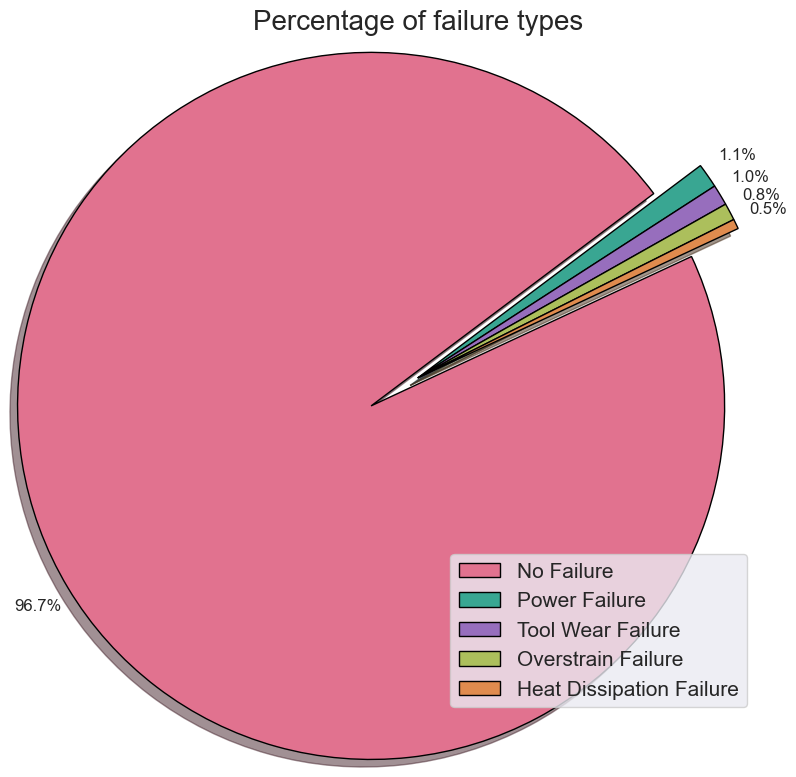

In [77]:
columns_failure_type = df['Failure Type'].unique().tolist()  # Types of failures

plt.rcParams["figure.figsize"] = (8,8)
colors = ['#E1728F', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E']

plt.pie(df['Failure Type'].value_counts(), explode=(0.2, 0, 0, 0, 0), autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, shadow=True, startangle=25,
        pctdistance=1.1, radius=1.3, colors=colors)
plt.legend(columns_failure_type, loc='lower right', fontsize=15)

plt.title('Percentage of failure types', fontsize=20)
plt.tight_layout()

Nous remarquons qu'il ya un très grand désiquimibre entre les dofferentes classes ou nous constatons qu'il la classe "No Failure" est dominante par rapport au autre classe avec 96.7% 

Failures percentage in data: 3.31


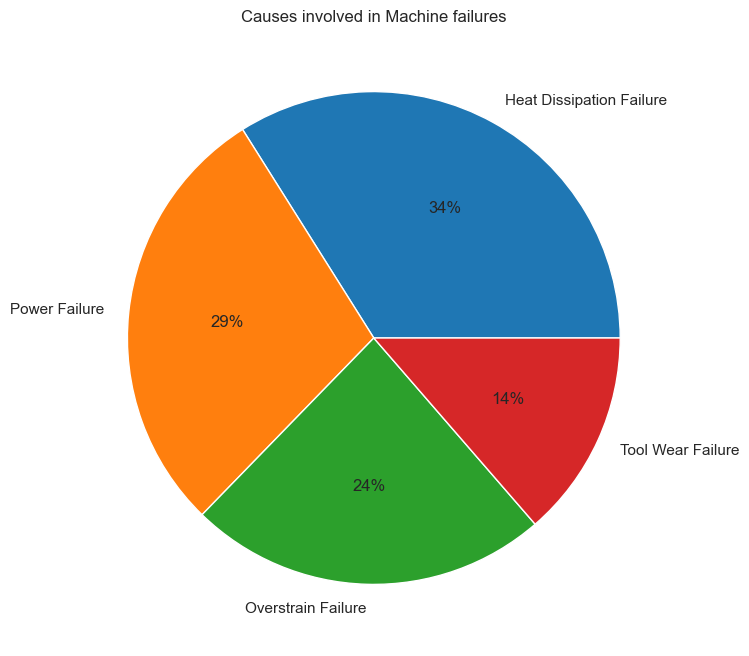

In [78]:
# Portion of df where there is a failure and causes percentage
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/n,2))
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

nous remarquons qu il ya aussi une autre désiquilbre dans les types de pannes 

Pourquoi SMOTENC et pas SMOTE ?
Parce que certaines colonnes sont catégoriques et doivent être traitées différemment.

In [79]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

In [80]:
# Vérification de la distribution des classes après rééchantillonnage
import pandas as pd

# Créer une série pandas à partir de y_res
class_counts = pd.Series(y_res).value_counts()

# Affichage du nombre d'échantillons par classe
print("Répartition des classes après rééchantillonnage :")
print(class_counts)

Répartition des classes après rééchantillonnage :
No Failure                  9643
Power Failure                603
Tool Wear Failure            603
Overstrain Failure           603
Heat Dissipation Failure     603
Name: Failure Type, dtype: int64


 Comparison after resampling 

Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


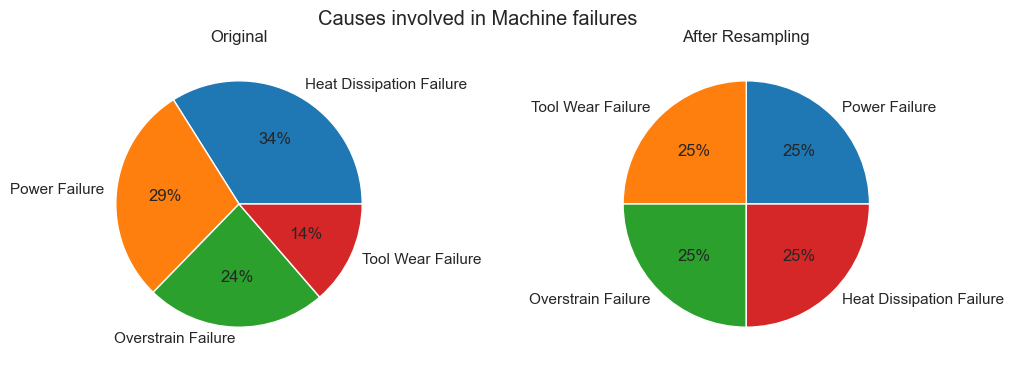

In [81]:
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

# Pie plot
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

Features scaling and Encoding 

Afin de rendre les données exploitables pour les algorithmes que nous allons exécuter, nous appliquons deux transformations :

Premièrement, nous appliquons un codage d'étiquettes aux colonnes catégorielles, car le Type est une caractéristique ordinale et la Cause doit être représentée dans une seule colonne. Le mappage suit le schéma suivant : Type : {L=0, M=1, H=2}

Deuxièmement, nous effectuons la mise à l'échelle des colonnes avec StandardScaler.

In [82]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features]) 

In [83]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import time

# train-test split
X, y = df_pre[features], df_pre[[ 'Failure Type']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.1, 
    stratify=y['Failure Type'], 
    random_state=0
)


 Models 

Pour chaque modèle, nous lançons la recherche par  Gridsearch pour l'optimisation des hyperparamètres

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pandas as pd
import time


# Instanciation des modèles
knn = KNeighborsClassifier()
svc = SVC(decision_function_shape='ovr')
rfc = RandomForestClassifier()
xgb = XGBClassifier()


# Listes de modèles et de noms
clf = [knn, svc, rfc, xgb]
clf_str = ['KNN', 'SVC', 'RFC', 'XGB']

# Grilles de recherche
knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[100,300],
              'max_depth':[5,7],
              'learning_rate':[0.01,0.1],
              'objective':['multi:softprob'],
              'use_label_encoder': [False],
              'eval_metric': ['mlogloss'],
              'random_state':[0]}



# Associer chaque modèle à ses paramètres
params = pd.Series(data=[knn_params, svc_params, rfc_params, xgb_params], index=clf)

# Fonction de tuning
def tune_and_fit(model, X, y, param_grid, multi_class='auto'):
    grid = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)
    grid.fit(X, y)
    print("Best parameters:", grid.best_params_)
    print("Best score:", grid.best_score_)
    return grid.best_estimator_

# Boucle GridSearch
print('GridSearch start')
fitted_models_multi = []
for model, model_name in zip(clf, clf_str):
    print('Training', model_name)
    best_model = tune_and_fit(model, X_train, y_train, params[model], multi_class='multi_class')
    fitted_models_multi.append(best_model)


GridSearch start
Training KNN
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\yaici\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Best parameters: {'n_neighbors': 1}
Best score: 0.9548348435322221
Training SVC
Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\yaici\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Best score: 0.9681079819730329
Training RFC
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\yaici\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters: {'max_depth': 10, 'n_estimators': 300, 'random_state': 0}
Best score: 0.9742836494821651
Training XGB
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\yaici\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'objective': 'multi:softprob', 'random_state': 0, 'use_label_encoder': False}
Best score: 0.9816577200584261


In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd



# Meilleurs modèles avec les hyperparamètres trouvés
models = {
    'KNN': KNeighborsClassifier(n_neighbors=1),
    'SVC': SVC(C=100, gamma=1, kernel='rbf', probability=True, random_state=0),
    'RFC': RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0),
    'XGB': XGBClassifier(eval_metric='mlogloss', learning_rate=0.1, max_depth=7, n_estimators=300,
                         objective='multi:softprob', random_state=0, use_label_encoder=False),

}

# Évaluer chaque modèle
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1 Score': round(f1, 4)
    })

# Afficher les résultats
df_results = pd.DataFrame(results)
print(df_results)


c:\Users\yaici\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\yaici\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\yaici\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\yaici\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1

  Model  Accuracy  Precision  Recall  F1 Score
0   KNN    0.9635     0.9646  0.9635    0.9638
1   SVC    0.9726     0.9733  0.9726    0.9729
2   RFC    0.9743     0.9746  0.9743    0.9744
3   XGB    0.9859     0.9858  0.9859    0.9859


In [86]:
print(y_test['Failure Type'].value_counts())


0    965
1     61
2     60
3     60
4     60
Name: Failure Type, dtype: int64


KNN Results
Accuracy: 0.9635157545605307
Recall: 0.9409728474758629
Precision: 0.9084360189683359
F1 Score: 0.9238640912394397


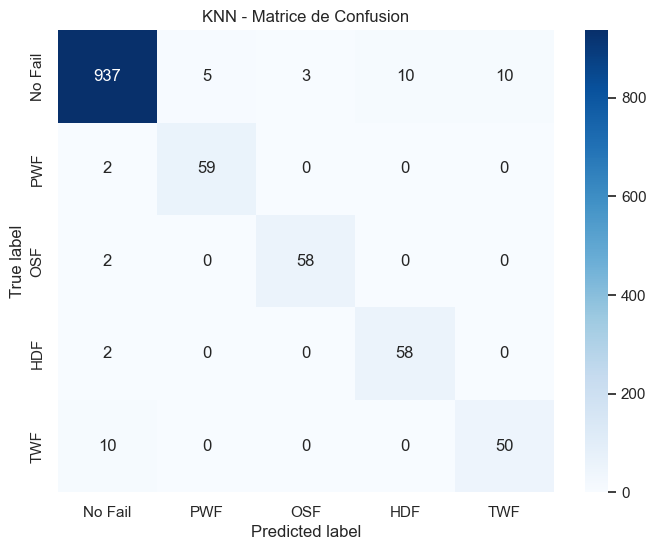

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Labels des classes
labels = ['No Fail', 'PWF', 'OSF', 'HDF', 'TWF']

# Modèle KNN entraîné avec meilleurs paramètres
knn_best = KNeighborsClassifier(n_neighbors=1)
knn_best.fit(X_train, y_train['Failure Type'])
y_pred_knn = knn_best.predict(X_test)

# Affichage des métriques
print("KNN Results")
print("Accuracy:", accuracy_score(y_test['Failure Type'], y_pred_knn))
print("Recall:", recall_score(y_test['Failure Type'], y_pred_knn, average='macro'))
print("Precision:", precision_score(y_test['Failure Type'], y_pred_knn, average='macro'))
print("F1 Score:", f1_score(y_test['Failure Type'], y_pred_knn, average='macro'))

# Matrice de confusion joliment formatée
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test['Failure Type'], y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("KNN - Matrice de Confusion")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


SVC Results
Accuracy: 0.972636815920398
Recall: 0.9495047991166228
Precision: 0.9368553213635181
F1 Score: 0.9428266862642326


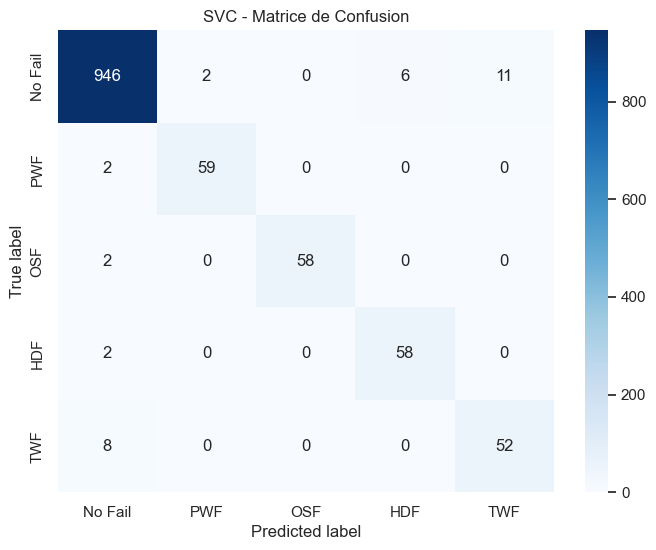

In [88]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Labels
labels = ['No Fail', 'PWF', 'OSF', 'HDF', 'TWF']

# Modèle SVC avec meilleurs paramètres
svc_best = SVC(C=100, gamma=1, kernel='rbf', probability=True, random_state=0)
svc_best.fit(X_train, y_train['Failure Type'])
y_pred_svc = svc_best.predict(X_test)

# Métriques
print("SVC Results")
print("Accuracy:", accuracy_score(y_test['Failure Type'], y_pred_svc))
print("Recall:", recall_score(y_test['Failure Type'], y_pred_svc, average='macro'))
print("Precision:", precision_score(y_test['Failure Type'], y_pred_svc, average='macro'))
print("F1 Score:", f1_score(y_test['Failure Type'], y_pred_svc, average='macro'))

# Matrice de confusion
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test['Failure Type'], y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("SVC - Matrice de Confusion")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


Random Forest Results
Accuracy: 0.9742951907131011
Recall: 0.9467932274413207
Precision: 0.9417724829808135
F1 Score: 0.9442112743965432


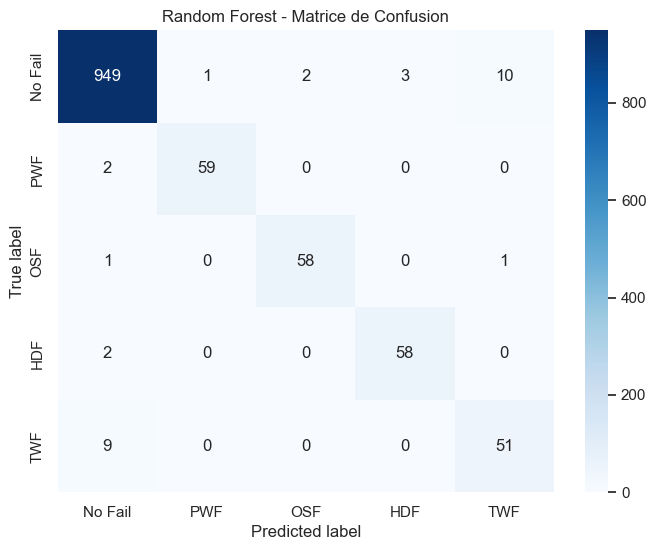

In [89]:
from sklearn.ensemble import RandomForestClassifier

# Modèle RFC avec meilleurs paramètres
rfc_best = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0)
rfc_best.fit(X_train, y_train['Failure Type'])
y_pred_rfc = rfc_best.predict(X_test)

# Métriques
print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test['Failure Type'], y_pred_rfc))
print("Recall:", recall_score(y_test['Failure Type'], y_pred_rfc, average='macro'))
print("Precision:", precision_score(y_test['Failure Type'], y_pred_rfc, average='macro'))
print("F1 Score:", f1_score(y_test['Failure Type'], y_pred_rfc, average='macro'))

# Matrice de confusion
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test['Failure Type'], y_pred_rfc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Random Forest - Matrice de Confusion")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


C:\Users\yaici\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results
Accuracy: 0.9859038142620232
Recall: 0.9652705342733373
Precision: 0.97426156791334
F1 Score: 0.9697254383875717


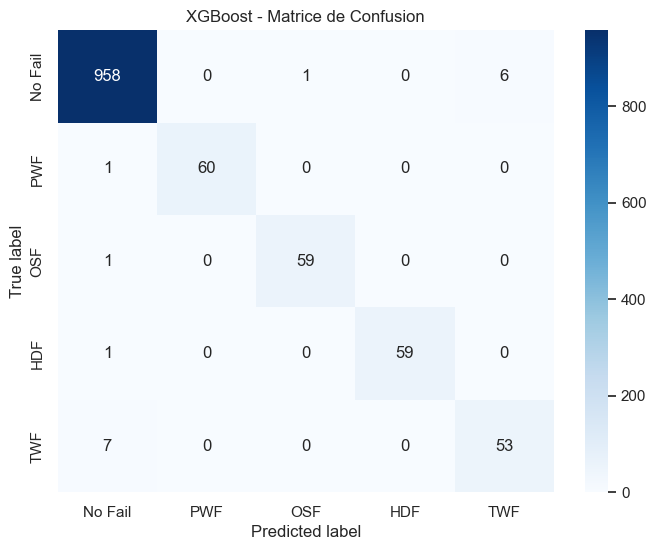

In [90]:
from xgboost import XGBClassifier

# Modèle XGB avec meilleurs paramètres
xgb_best = XGBClassifier(objective='multi:softprob', learning_rate=0.1, max_depth=7,
                         n_estimators=300, use_label_encoder=False,
                         eval_metric='mlogloss', random_state=0)
xgb_best.fit(X_train, y_train['Failure Type'])
y_pred_xgb = xgb_best.predict(X_test)

# Métriques
print("XGBoost Results")
print("Accuracy:", accuracy_score(y_test['Failure Type'], y_pred_xgb))
print("Recall:", recall_score(y_test['Failure Type'], y_pred_xgb, average='macro'))
print("Precision:", precision_score(y_test['Failure Type'], y_pred_xgb, average='macro'))
print("F1 Score:", f1_score(y_test['Failure Type'], y_pred_xgb, average='macro'))

# Matrice de confusion
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test['Failure Type'], y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("XGBoost - Matrice de Confusion")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [91]:
#  Enregistrement avec pickle
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_best, f)

with open('svc_model.pkl', 'wb') as f:
    pickle.dump(svc_best, f)

with open('rfc_model.pkl', 'wb') as f:
    pickle.dump(rfc_best, f)

with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_best, f)

In [92]:
import numpy as np
import pandas as pd
import pickle

# Charger le dictionnaire de correspondance des classes
with open("class_mapping.pkl", "rb") as f:
    class_mapping = pickle.load(f)

# Charger le dictionnaire d'encodage du Type
with open("encodage_type.pkl", "rb") as f:
    type_dict = pickle.load(f)

# Définir les nouvelles données
new_data = {
    'Type': 'L',
    'Air temperature': 298.4,
    'Process temperature': 308.2,
    'Rotational speed': 1282,
    'Torque': 60.7,
    'Tool wear': 216
}

# Encodage de la colonne Type en utilisant le fichier pickle
new_data['Type'] = type_dict[new_data['Type']]

# Conversion en DataFrame
X_new = pd.DataFrame([new_data])

# Séparer Type (non scalé) et les autres colonnes
num_features = ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']

# Charger le StandardScaler entraîné
with open("scaler.pkl", "rb") as f:
    sc = pickle.load(f)

X_new_scaled = sc.transform(X_new[num_features])  # Appliquer le scaler sur les features numériques
X_new_final = np.column_stack((X_new['Type'].values, X_new_scaled))  # Ajouter Type après scaling

# Charger le modèle XGBoost sauvegardé
with open("xgb_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

# Prédire la classe
predicted_class_index = xgb_model.predict(X_new_final)[0]

# Convertir l'index en nom de classe
predicted_class_name = class_mapping[predicted_class_index]

print(f"Prédiction : {predicted_class_name}")


Prédiction : Overstrain Failure


In [93]:
# Sauvegarder le DataFrame df dans un fichier CSV
df.to_csv('data_sans_RandomFaillure.csv', index=False)

In [94]:
print(df['Failure Type'].value_counts())

No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: Failure Type, dtype: int64
